In [2]:
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
from transformer_lens import HookedTransformer
from muutils.dictmagic import condense_tensor_dict

In [3]:

# Functions from original paper
def normalize(R):
    with torch.no_grad():
        mean = R.mean(dim=0)
        R = R - mean
        norms = torch.norm(R, p=2, dim=1, keepdim=True)
        R = R/norms
    return R

def cal_cov(R):
    with torch.no_grad():
        Z = torch.nn.functional.normalize(R, dim=1)
        A = torch.matmul(Z.T, Z)/Z.shape[0]
    return A

def cal_entropy(A):
    with torch.no_grad():
        eig_val = torch.svd(A / torch.trace(A))[1] 
        entropy = - (eig_val * torch.log(eig_val)).nansum().item()
        normalized_entropy = entropy/math.log(A.shape[0])
    return normalized_entropy



# Input prompt and transformer lens model, and the model layers number
def entropy_cal_fn(prompt,MODEL): 
    TOKENIZER = MODEL.tokenizer
    input_ids = TOKENIZER.encode(prompt)
    logits, cache = MODEL.run_with_cache(
        prompt,
    )

    layers_num = MODEL.cfg.n_layers
    layers = []
    firstLayer = "blocks.0.hook_resid_post"

    for i in range(layers_num):
        new_string = firstLayer.replace("0", str(i))
        layers.append(new_string)

    Entropy = []

    for i in range(layers_num):
        with torch.no_grad():
            R = cache[layers[i]][0]
            R = normalize(R)
            A = cal_cov(R)
            Entropy.append(cal_entropy(A))

    return Entropy


# Calculate mean and std of matrix entropy of a set of prompt 
def entropy_cal_dataset(prompt,MODEL):
    Entropy = []
    for i in range(len(prompt)):
        Entropy.append(entropy_cal_fn(prompt[i], MODEL))
    Entropy_np = np.array(Entropy)
    Entropy_means = np.mean(Entropy_np, axis=0)
    Entropy_std = np.std(Entropy_np, axis=0)

    return Entropy_means, Entropy_std
    



## Models

In [11]:
MODEL: HookedTransformer = HookedTransformer.from_pretrained("tiny-stories-28M")

Loaded pretrained model tiny-stories-28M into HookedTransformer


In [3]:
MODEL1: HookedTransformer = HookedTransformer.from_pretrained("tiny-stories-3M")
MODEL2: HookedTransformer = HookedTransformer.from_pretrained("gpt2")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Loaded pretrained model tiny-stories-3M into HookedTransformer
Loaded pretrained model gpt2 into HookedTransformer


In [4]:
MODEL3: HookedTransformer = HookedTransformer.from_pretrained("gpt2-medium")

Loaded pretrained model gpt2-medium into HookedTransformer


In [4]:
MODEL4: HookedTransformer = HookedTransformer.from_pretrained("gpt2-large")

Loaded pretrained model gpt2-large into HookedTransformer


### Test on single prompt

In [3]:
prompt1 = "The Three Little Pigs is a beloved folk tale that tells the story of three pigs, each building a house out of different materials: straw, sticks, and bricks. The youngest pig opts for straw, the middle pig chooses sticks, while the eldest builds his house out of bricks. When a big bad wolf comes to eat them, he easily destroys the first two houses by huffing and puffing, devouring the first two pigs. However, the third pig's brick house withstands the wolf's attempts. Frustrated, the wolf tries to enter through the chimney, but the clever pig boils a pot of water just in time, ending the wolf's threat once and for all. This classic tale highlights the virtues of hard work and resourcefulness, as the most diligent and smartest pig not only survives but thrives."
prompt2 = "In the gloomy depths of a forsaken city, plagued by perpetual storms and decay, a series of calamities unfolded one after another, casting a shadow of despair across the broken streets. Buildings crumbled under the relentless rain, streets flooded, trapping residents in their homes as cries for help echoed through the night. A mysterious illness swept through the population, its origins unknown, causing widespread panic and chaos. Amidst the pandemonium, crime soared as desperate survivors looted abandoned homes and fought over scarce resources. The city, once bustling with life, turned into a dystopian nightmare where hope dwindled with each passing day, and the darkness seemed to swallow everything in its path."


condense_prompt1 = "The Three Little Pigs is a folk tale about three pigs building houses of straw, sticks, and bricks. A wolf destroys the first two houses and eats the pigs, but fails to break the third pig's brick house. Thwarted, the wolf's final attempt through the chimney ends disastrously, illustrating the rewards of hard work and ingenuity."
condense_prompt2 = "In a forsaken city hit by continuous storms and decay, calamities struck relentlessly. Buildings fell, streets flooded, and a mysterious illness caused chaos and panic. Crime surged as survivors looted and fought over dwindling resources, turning the once vibrant city into a dark, dystopian nightmare where hope faded daily."


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Loaded pretrained model tiny-stories-3M into HookedTransformer
Loaded pretrained model gpt2 into HookedTransformer


### Calculate single prompt matrix entropy

In [56]:
Entropy_Tiny_1 = entropy_cal_fn(prompt1,MODEL1)
Entropy_Tiny_2 = entropy_cal_fn(prompt2,MODEL1)

Entropy_GPT_1 = entropy_cal_fn(prompt1,MODEL2)
Entropy_GPT_2 = entropy_cal_fn(prompt2,MODEL2)

In [57]:
Entropy_Tiny_1_cond = entropy_cal_fn(condense_prompt1,MODEL1)
Entropy_Tiny_2_cond = entropy_cal_fn(condense_prompt2,MODEL1)

Entropy_GPT_1_cond = entropy_cal_fn(condense_prompt1,MODEL2)
Entropy_GPT_2_cond = entropy_cal_fn(condense_prompt2,MODEL2)

#### Tiny story 

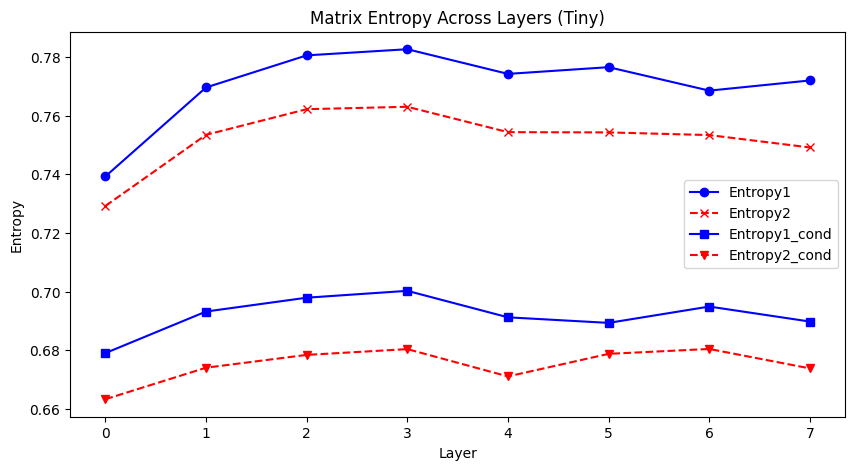

In [58]:
x_values = list(range(len(Entropy_Tiny_1)))

plt.figure(figsize=(10, 5))
plt.plot(x_values, Entropy_Tiny_1, marker='o', linestyle='-', color='b', label='Entropy1')  
plt.plot(x_values, Entropy_Tiny_2, marker='x', linestyle='--', color='r', label='Entropy2') 
plt.plot(x_values, Entropy_Tiny_1_cond, marker='s', linestyle='-', color='b', label='Entropy1_cond')  
plt.plot(x_values, Entropy_Tiny_2_cond, marker='v', linestyle='--', color='r', label='Entropy2_cond')  

plt.legend()
plt.title('Matrix Entropy Across Layers (Tiny)')
plt.xlabel('Layer') 
plt.ylabel('Entropy')  
plt.grid(False) 
plt.xticks(x_values) 
plt.show()

#### GPT2 small

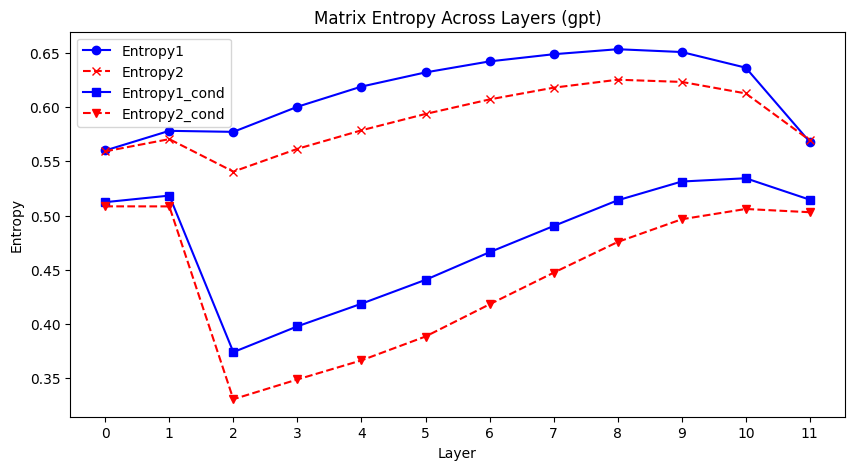

In [59]:
x_values = list(range(len(Entropy_GPT_1)))

plt.figure(figsize=(10, 5))
plt.plot(x_values, Entropy_GPT_1, marker='o', linestyle='-', color='b', label='Entropy1')  
plt.plot(x_values, Entropy_GPT_2, marker='x', linestyle='--', color='r', label='Entropy2') 
plt.plot(x_values, Entropy_GPT_1_cond, marker='s', linestyle='-', color='b', label='Entropy1_cond')  
plt.plot(x_values, Entropy_GPT_2_cond, marker='v', linestyle='--', color='r', label='Entropy2_cond')  

plt.legend()
plt.title('Matrix Entropy Across Layers (gpt)')
plt.xlabel('Layer') 
plt.ylabel('Entropy')  
plt.grid(False) 
plt.xticks(x_values) 
plt.show()

### 10 Good & bad child stories long & condensed 

In [5]:
import json
def load_json_data(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    return data


In [13]:
child_stories = load_json_data('./data/child_stories.json')
stories_good_long = child_stories['Good Stories']['Long']
stories_bad_long = child_stories['Bad Stories']['Long']

stories_good_cond = child_stories['Good Stories']['Condensed']
stories_bad_cond = child_stories['Bad Stories']['Condensed']

#### Tiny Story 3M matrix entropy cal

In [9]:
Entropy_Tiny_good_long_mean, Entropy_Tiny_good_long_std = entropy_cal_dataset(stories_good_long,MODEL1)
Entropy_Tiny_bad_long_mean, Entropy_Tiny_bad_long_std = entropy_cal_dataset(stories_bad_long,MODEL1)
Entropy_Tiny_good_cond_mean, Entropy_Tiny_good_cond_std = entropy_cal_dataset(stories_good_cond,MODEL1)
Entropy_Tiny_bad_cond_mean, Entropy_Tiny_bad_cond_std = entropy_cal_dataset(stories_bad_cond,MODEL1)

/var/folders/08/h4ttblxd6m5fjbzyhmxs4bk00000gn/T/ipykernel_86277/1673496301.py:18: UserWarning: The operator 'aten::linalg_svd' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  eig_val = torch.svd(A / torch.trace(A))[1]


#### Tiny Story 28M matrix entropy cal

In [14]:
Entropy_Tiny_l_good_long_mean, Entropy_Tiny_l_good_long_std = entropy_cal_dataset(stories_good_long,MODEL)
Entropy_Tiny_l_bad_long_mean, Entropy_Tiny_l_bad_long_std = entropy_cal_dataset(stories_bad_long,MODEL)
Entropy_Tiny_l_good_cond_mean, Entropy_Tiny_l_good_cond_std = entropy_cal_dataset(stories_good_cond,MODEL)
Entropy_Tiny_l_bad_cond_mean, Entropy_Tiny_l_bad_cond_std = entropy_cal_dataset(stories_bad_cond,MODEL)

#### GPT2 small matrix entropy cal

In [49]:
Entropy_GPT_good_long_mean, Entropy_GPT_good_long_std = entropy_cal_dataset(stories_good_long,MODEL2)
Entropy_GPT_bad_long_mean, Entropy_GPT_bad_long_std = entropy_cal_dataset(stories_bad_long,MODEL2)
Entropy_GPT_good_cond_mean, Entropy_GPT_good_cond_std = entropy_cal_dataset(stories_good_cond,MODEL2)
Entropy_GPT_bad_cond_mean, Entropy_GPT_bad_cond_std = entropy_cal_dataset(stories_bad_cond,MODEL2)

#### GPT2 medium 

In [14]:
Entropy_GPT_m_good_long_mean, Entropy_GPT_m_good_long_std = entropy_cal_dataset(stories_good_long,MODEL3)
Entropy_GPT_m_bad_long_mean, Entropy_GPT_m_bad_long_std = entropy_cal_dataset(stories_bad_long,MODEL3)
Entropy_GPT_m_good_cond_mean, Entropy_GPT_m_good_cond_std = entropy_cal_dataset(stories_good_cond,MODEL3)
Entropy_GPT_m_bad_cond_mean, Entropy_GPT_m_bad_cond_std = entropy_cal_dataset(stories_bad_cond,MODEL3)

#### GPT2 large

In [6]:
Entropy_GPT_l_good_long_mean, Entropy_GPT_l_good_long_std = entropy_cal_dataset(stories_good_long,MODEL4)
Entropy_GPT_l_bad_long_mean, Entropy_GPT_l_bad_long_std = entropy_cal_dataset(stories_bad_long,MODEL4)
Entropy_GPT_l_good_cond_mean, Entropy_GPT_l_good_cond_std = entropy_cal_dataset(stories_good_cond,MODEL4)
Entropy_GPT_l_bad_cond_mean, Entropy_GPT_l_bad_cond_std = entropy_cal_dataset(stories_bad_cond,MODEL4)

/var/folders/08/h4ttblxd6m5fjbzyhmxs4bk00000gn/T/ipykernel_85598/1673496301.py:18: UserWarning: The operator 'aten::linalg_svd' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  eig_val = torch.svd(A / torch.trace(A))[1]


### Plot across layers

In [18]:
def plot_across_layers (
    Entropy_one_mean,   
    Entropy_one_std,
    Entropy_sec_mean,   
    Entropy_sec_std,
    Entropy_thr_mean = None,   
    Entropy_thr_std = None,
    Entropy_fo_mean = None,   
    Entropy_fo_std = None,
):

    x_values = list(range(len(Entropy_one_mean)))

    plt.figure(figsize=(10, 5))
    plt.errorbar(x_values, Entropy_one_mean, yerr=Entropy_one_std, marker='o', linestyle='-', color='b', label='Entropy 1')
    plt.errorbar(x_values, Entropy_sec_mean, yerr=Entropy_sec_std, marker='o', linestyle='--', color='r', label='Entropy 2')

    if Entropy_thr_mean is not None and Entropy_thr_std is not None:
        plt.errorbar(x_values, Entropy_thr_mean, yerr=Entropy_thr_std, marker='s', linestyle='-', color='b', label='Entropy 3')

    if Entropy_fo_mean is not None and Entropy_fo_std is not None:
        plt.errorbar(x_values, Entropy_fo_mean, yerr=Entropy_fo_std, marker='v', linestyle='--', color='r', label='Entropy 4')
    
    plt.legend()
    plt.title('Mean Matrix Entropy Across Layers')
    plt.xlabel('Layer') 
    plt.ylabel('Entropy')  
    plt.grid(False) 
    plt.xticks(x_values) 
    plt.show()


## Mean Matrix Entropy Across Layers for 10 child stories

#### Tiny Story 3M

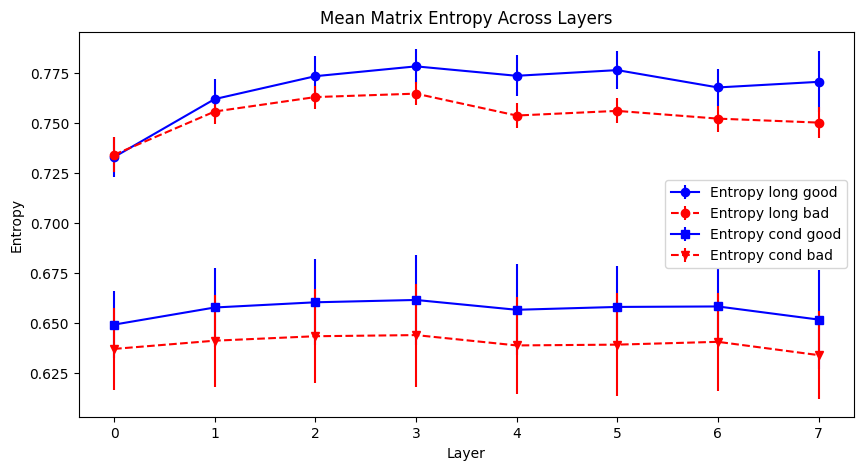

In [57]:

plot_across_layers(
    Entropy_Tiny_good_long_mean,
    Entropy_Tiny_good_long_std,
    Entropy_Tiny_bad_long_mean,
    Entropy_Tiny_bad_long_std,
    Entropy_Tiny_good_cond_mean,
    Entropy_Tiny_good_cond_std,
    Entropy_Tiny_bad_cond_mean,
    Entropy_Tiny_bad_cond_std
)

#### Tiny Story 28M 

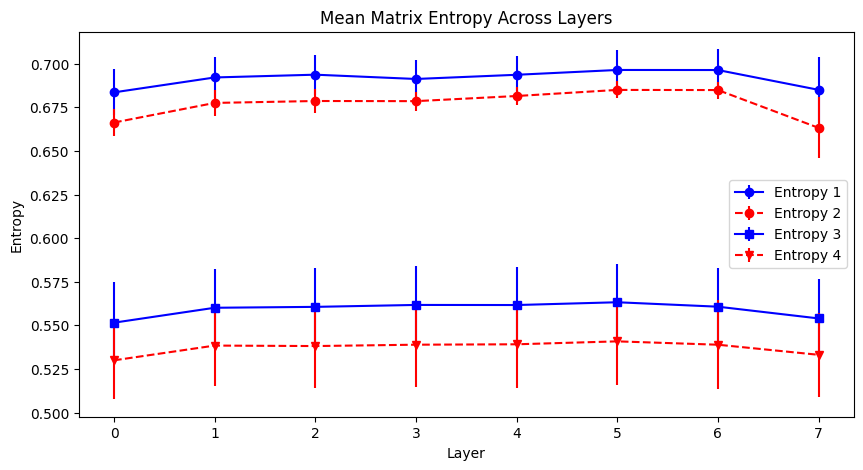

In [19]:
plot_across_layers(
    Entropy_Tiny_l_good_long_mean,
    Entropy_Tiny_l_good_long_std,
    Entropy_Tiny_l_bad_long_mean,
    Entropy_Tiny_l_bad_long_std,
    Entropy_Tiny_l_good_cond_mean,
    Entropy_Tiny_l_good_cond_std,
    Entropy_Tiny_l_bad_cond_mean,
    Entropy_Tiny_l_bad_cond_std
)

#### GPT2 Small

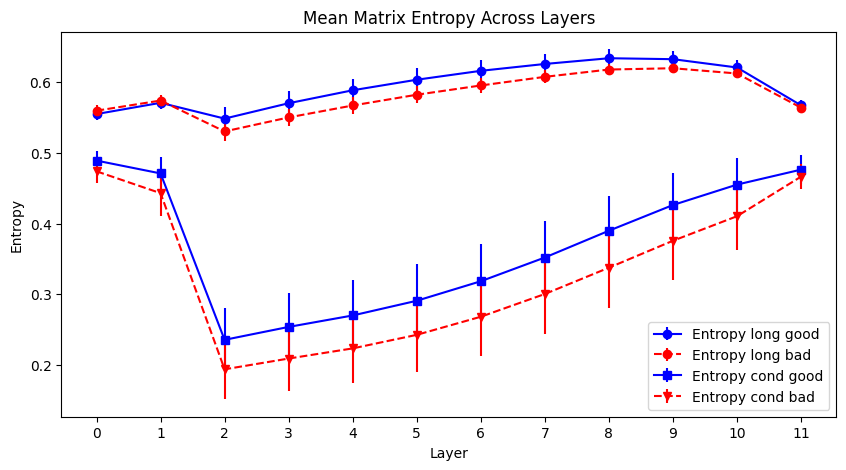

In [53]:
plot_across_layers(
    Entropy_GPT_good_long_mean,
    Entropy_GPT_good_long_std,
    Entropy_GPT_bad_long_mean,
    Entropy_GPT_bad_long_std,
    Entropy_GPT_good_cond_mean,
    Entropy_GPT_good_cond_std,
    Entropy_GPT_bad_cond_mean,
    Entropy_GPT_bad_cond_std
)

#### GPT2 Medium

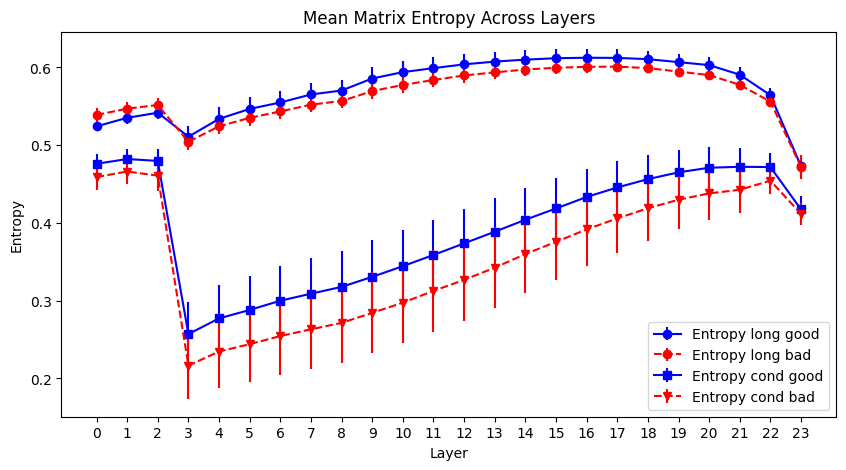

In [17]:
plot_across_layers(
    Entropy_GPT_m_good_long_mean,
    Entropy_GPT_m_good_long_std,
    Entropy_GPT_m_bad_long_mean,
    Entropy_GPT_m_bad_long_std,
    Entropy_GPT_m_good_cond_mean,
    Entropy_GPT_m_good_cond_std,
    Entropy_GPT_m_bad_cond_mean,
    Entropy_GPT_m_bad_cond_std
)

#### GPT2 Large

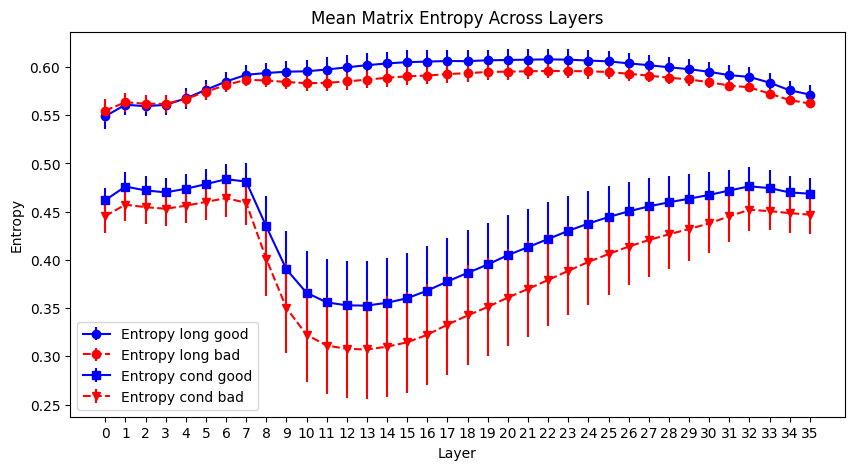

In [19]:
plot_across_layers(
    Entropy_GPT_l_good_long_mean,
    Entropy_GPT_l_good_long_std,
    Entropy_GPT_l_bad_long_mean,
    Entropy_GPT_l_bad_long_std,
    Entropy_GPT_l_good_cond_mean,
    Entropy_GPT_l_good_cond_std,
    Entropy_GPT_l_bad_cond_mean,
    Entropy_GPT_l_bad_cond_std
)


## Mean Matrix Entropy for Utopian & Dystopian stories

In [7]:
worlds_stories = load_json_data('./data/worlds_stories.json')

utopian_stories = worlds_stories['Utopian Worlds']
dystopian_stories = worlds_stories['Dystopian Worlds']

#### Tiny

In [71]:
Entropy_tiny_utopian_mean, Entropy_tiny_utopian_std = entropy_cal_dataset(utopian_stories,MODEL1)
Entropy_tiny_dytopian_mean, Entropy_tiny_dytopian_std = entropy_cal_dataset(dystopian_stories,MODEL1)

#### Tiny 28M

In [20]:
Entropy_tiny_l_utopian_mean, Entropy_tiny_l_utopian_std = entropy_cal_dataset(utopian_stories,MODEL)
Entropy_tiny_l_dytopian_mean, Entropy_tiny_l_dytopian_std = entropy_cal_dataset(dystopian_stories,MODEL)

#### GPT2 small

In [73]:
Entropy_gpt_utopian_mean, Entropy_gpt_utopian_std = entropy_cal_dataset(utopian_stories,MODEL2)
Entropy_gpt_dytopian_mean, Entropy_gpt_dytopian_std = entropy_cal_dataset(dystopian_stories,MODEL2)

#### GPT2 medium

In [74]:
Entropy_gpt_m_utopian_mean, Entropy_gpt_m_utopian_std = entropy_cal_dataset(utopian_stories,MODEL3)
Entropy_gpt_m_dytopian_mean, Entropy_gpt_m_dytopian_std = entropy_cal_dataset(dystopian_stories,MODEL3)

#### GPT2 large

In [8]:
Entropy_gpt_l_utopian_mean, Entropy_gpt_l_utopian_std = entropy_cal_dataset(utopian_stories,MODEL4)
Entropy_gpt_l_dytopian_mean, Entropy_gpt_l_dytopian_std = entropy_cal_dataset(dystopian_stories,MODEL4)

/var/folders/08/h4ttblxd6m5fjbzyhmxs4bk00000gn/T/ipykernel_12897/1231632730.py:18: UserWarning: The operator 'aten::linalg_svd' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  eig_val = torch.svd(A / torch.trace(A))[1]


#### plot

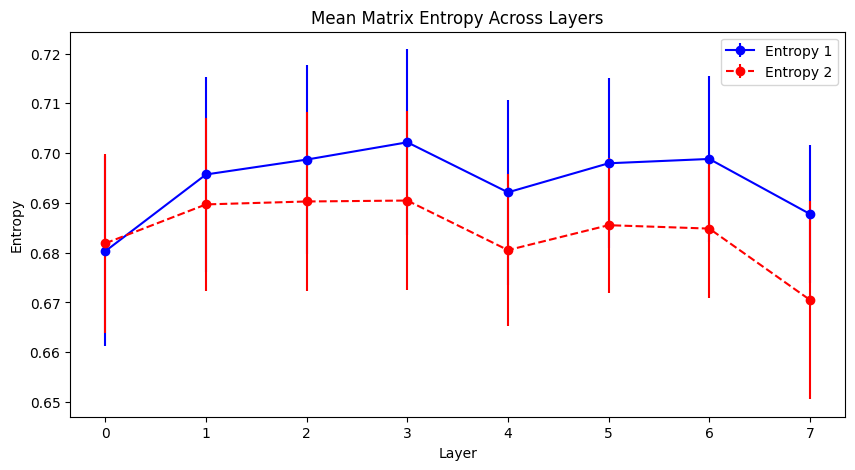

In [72]:
plot_across_layers(
    Entropy_tiny_utopian_mean,
    Entropy_tiny_utopian_std,
    Entropy_tiny_dytopian_mean,
    Entropy_tiny_dytopian_std,
    None,
    None,
    None,
    None
)

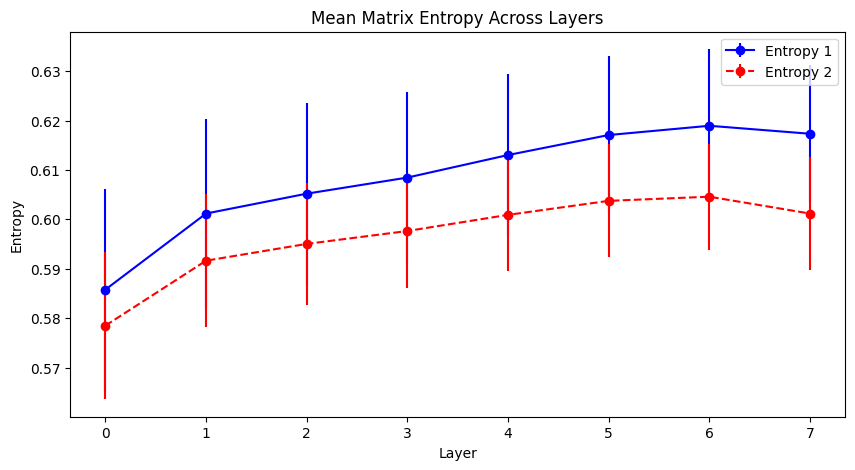

In [21]:
plot_across_layers(
    Entropy_tiny_l_utopian_mean,
    Entropy_tiny_l_utopian_std,
    Entropy_tiny_l_dytopian_mean,
    Entropy_tiny_l_dytopian_std,
    None,
    None,
    None,
    None
)

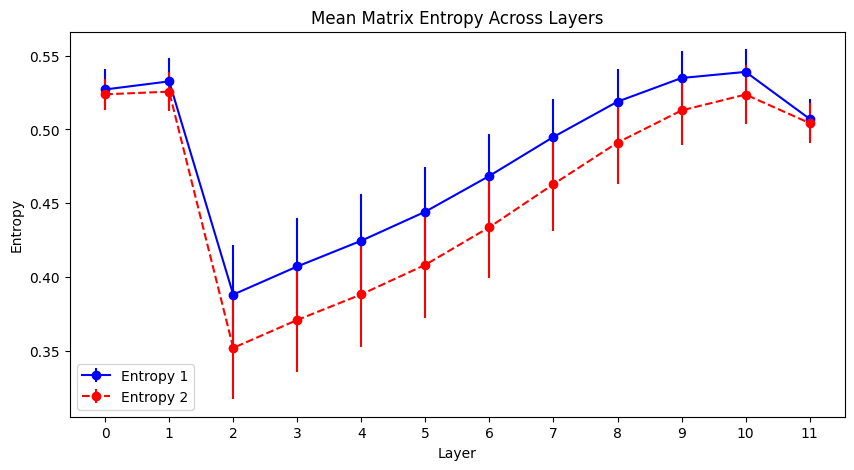

In [75]:
plot_across_layers(
    Entropy_gpt_utopian_mean,
    Entropy_gpt_utopian_std,
    Entropy_gpt_dytopian_mean,
    Entropy_gpt_dytopian_std,
    None,
    None,
    None,
    None
)

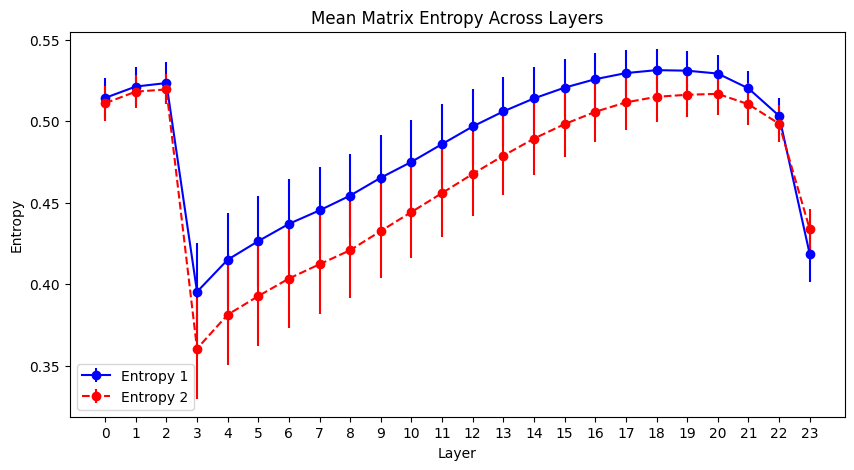

In [76]:
plot_across_layers(
    Entropy_gpt_m_utopian_mean,
    Entropy_gpt_m_utopian_std,
    Entropy_gpt_m_dytopian_mean,
    Entropy_gpt_m_dytopian_std,
    None,
    None,
    None,
    None
)

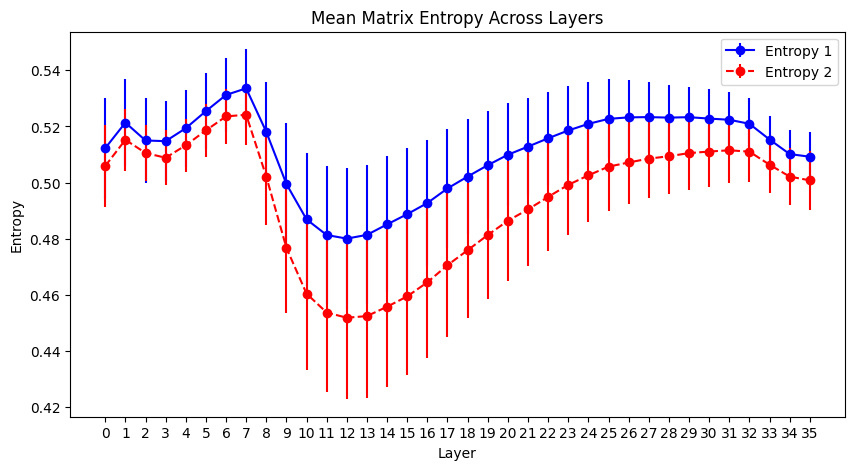

In [9]:
plot_across_layers(
    Entropy_gpt_l_utopian_mean,
    Entropy_gpt_l_utopian_std,
    Entropy_gpt_l_dytopian_mean,
    Entropy_gpt_l_dytopian_std,
    None,
    None,
    None,
    None
)